In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import os, sys
from scipy.stats import spearmanr
import sqlite3
import torch
from tqdm import tqdm

sys.path.insert(0, '../src')
sys.path.insert(1, '..')

from main import get_model
from models.config import Config, IMAGE_TOKEN_IDS
import db_utils, visualizations, utils, similarity_utils

/n/fs/ac-project/anaconda3/envs/vlm-lens-base/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Util Functions

In [27]:
# For each layer, calculate the mean similarity and the norm
def plot_similarities(module_names,
                      module_embeddings,
                      module_similarities,
                      model_name=''):
    '''
    Given list of module names, image embeddings (vision and text + vision), and similarities
    plot mean similarity score for each layer

    Arg(s):
        module_names : list[str]
        module_embeddings : list[2D np.array]
        module_similarities : list[1D np.array]
    '''
    mean_embeddings = {}
    mean_similarities = {}
    for idx, (name, embs, sims) in enumerate(zip(module_names, module_embeddings, module_similarities)):
        # Key is based on vision vs text
        key = name.split(".")[0]
        # If we are isolating vision token embeddings
        if "-" in name:
            key += "-{}".format(name.split("-")[1])
        if key in mean_embeddings:
            mean_embeddings[key].append(np.mean(embs))
        else:
            mean_embeddings[key] = [np.mean(embs)]

        if key in mean_similarities:
            mean_similarities[key].append(np.mean(sims))
        else:
            mean_similarities[key] = [np.mean(sims)]

    # Plot mean image-pair similarity scores by layer
    xs = []
    ys = []
    labels = []
    n_vision_layers = len(mean_embeddings["visual"]) # TODO: might throw an error if "visual" is wrong key
    for k, v in mean_similarities.items():
        if k.startswith("model"):
            xs.append([i + n_vision_layers for i in range(len(v))])
        else:
            xs.append([i for i in range(len(v))])
        ys.append(v)
        labels.append("{} blocks".format(k))

    print(ys)
    visualizations.plot(
        xs=xs,
        ys=ys,
        labels=labels,
        alpha=0.8,
        xlabel='Layer of {} Model'.format(model_name),
        ylabel='Mean Image Pairwise Similarity (0-1)',
        show=True
    )


# Qwen2-VL-2B-Instruct

In [7]:
sys.argv = ['notebooks/track_mean_sims_across_layers.ipynb',
            '--config', '../configs/models/qwen/Qwen2-VL-2B-Instruct-VisualBlocks.yaml']

config = Config()

In [8]:
model = get_model(config.architecture, config)

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


In [10]:
print("{:.3f}B parameters".format(model.model.num_parameters() / 1e9))
print(model.model)


2.209B parameters
Qwen2VLForConditionalGeneration(
  (visual): Qwen2VisionTransformerPretrainedModel(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2VLVisionBlock(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): VisionSdpaAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): VisionMlp(
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (act): QuickGELUActivation()
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
    )
    (merger): PatchMerger(
      (ln_q): LayerNorm((1280,), eps=1e-06, elementwise_affine=True

In [4]:
for name, module in model.model.named_modules():
    if model.config.matches_module(name):
        print(name)

visual.blocks.0
visual.blocks.1
visual.blocks.2
visual.blocks.3
visual.blocks.4
visual.blocks.5
visual.blocks.6
visual.blocks.7
visual.blocks.8
visual.blocks.9
visual.blocks.10
visual.blocks.11
visual.blocks.12
visual.blocks.13
visual.blocks.14
visual.blocks.15
visual.blocks.16
visual.blocks.17
visual.blocks.18
visual.blocks.19
visual.blocks.20
visual.blocks.21
visual.blocks.22
visual.blocks.23
visual.blocks.24
visual.blocks.25
visual.blocks.26
visual.blocks.27
visual.blocks.28
visual.blocks.29
visual.blocks.30
visual.blocks.31
visual.merger
model.layers.0
model.layers.1
model.layers.2
model.layers.3
model.layers.4
model.layers.5
model.layers.6
model.layers.7
model.layers.8
model.layers.9
model.layers.10
model.layers.11
model.layers.12
model.layers.13
model.layers.14
model.layers.15
model.layers.16
model.layers.17
model.layers.18
model.layers.19
model.layers.20
model.layers.21
model.layers.22
model.layers.23
model.layers.24
model.layers.25
model.layers.26
model.layers.27
model.norm


In [5]:
model.run(save_tokens=True)

Running forward hooks on data: 100%|██████████| 50/50 [01:07<00:00,  1.35s/it]


In [4]:
db_path = model.config.output_db
utils.informal_log(db_path)
connection = sqlite3.connect(db_path)
connection.row_factory = sqlite3.Row
cursor = connection.cursor()

[1020_090826] ../output/Qwen2-VL-2B-Instruct-VisualBlocks.db


In [7]:
for r in cursor.execute("""
  SELECT DISTINCT layer
  FROM tensors
"""):
    print(dict(r))

{'layer': 'input_ids'}
{'layer': 'visual.blocks.0'}
{'layer': 'visual.blocks.1'}
{'layer': 'visual.blocks.2'}
{'layer': 'visual.blocks.3'}
{'layer': 'visual.blocks.4'}
{'layer': 'visual.blocks.5'}
{'layer': 'visual.blocks.6'}
{'layer': 'visual.blocks.7'}
{'layer': 'visual.blocks.8'}
{'layer': 'visual.blocks.9'}
{'layer': 'visual.blocks.10'}
{'layer': 'visual.blocks.11'}
{'layer': 'visual.blocks.12'}
{'layer': 'visual.blocks.13'}
{'layer': 'visual.blocks.14'}
{'layer': 'visual.blocks.15'}
{'layer': 'visual.blocks.16'}
{'layer': 'visual.blocks.17'}
{'layer': 'visual.blocks.18'}
{'layer': 'visual.blocks.19'}
{'layer': 'visual.blocks.20'}
{'layer': 'visual.blocks.21'}
{'layer': 'visual.blocks.22'}
{'layer': 'visual.blocks.23'}
{'layer': 'visual.blocks.24'}
{'layer': 'visual.blocks.25'}
{'layer': 'visual.blocks.26'}
{'layer': 'visual.blocks.27'}
{'layer': 'visual.blocks.28'}
{'layer': 'visual.blocks.29'}
{'layer': 'visual.blocks.30'}
{'layer': 'visual.blocks.31'}
{'layer': 'visual.merger'}


In [26]:
for r in cursor.execute("""
  SELECT id, image_id, timestamp, name, image_path, prompt, label, layer, pooling_method, tensor_dim, tensor_shape,
         length(tensor) AS tensor_bytes
  FROM tensors
  LIMIT 20
"""):
    print(dict(r))

{'id': 1, 'image_id': None, 'timestamp': '2025-10-14 15:20:08', 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'image_path': '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000414795.jpg', 'prompt': 'Describe this image in one sentence.', 'label': None, 'layer': 'input_ids', 'pooling_method': None, 'tensor_dim': 1, 'tensor_shape': 'torch.Size([1, 172])', 'tensor_bytes': 2524}
{'id': 2, 'image_id': None, 'timestamp': '2025-10-14 15:20:08', 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'image_path': '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000414795.jpg', 'prompt': 'Describe this image in one sentence.', 'label': None, 'layer': 'visual.blocks.31', 'pooling_method': None, 'tensor_dim': 1280, 'tensor_shape': 'torch.Size([576, 1280])', 'tensor_bytes': 1475740}
{'id': 3, 'image_id': None, 'timestamp': '2025-10-14 15:20:08', 'name': 'Qwen/Qwen2-VL-2B-Instruct', 'image_path': '/n/fs/ac-vlm/vlm-lens/data_local/coco/cocoval/000000414795.jpg', 'prompt': 'Describe this image in one sentence.', 'label': No

### For each image, calculate similarity of embeddings between pairs of layers

In [74]:
layer_names = ["model.layers.{}".format(i) for i in range(28)]
layer_names += ["model.norm"]
m_names, m_embeddings, m_similarities = similarity_utils.compute_image_pair_similarities(
    database_path=db_path,
    model=model,
    layer_names=None,
    modalities=['vision', "text+vision"])

100%|██████████| 62/62 [03:08<00:00,  3.03s/it]


91
0 visual.blocks.0-vision
1 visual.blocks.0
2 visual.blocks.1-vision
3 visual.blocks.1
4 visual.blocks.2-vision
5 visual.blocks.2
6 visual.blocks.3-vision
7 visual.blocks.3
8 visual.blocks.4-vision
9 visual.blocks.4
10 visual.blocks.5-vision
11 visual.blocks.5
12 visual.blocks.6-vision
13 visual.blocks.6
14 visual.blocks.7-vision
15 visual.blocks.7
16 visual.blocks.8-vision
17 visual.blocks.8
18 visual.blocks.9-vision
19 visual.blocks.9
20 visual.blocks.10-vision
21 visual.blocks.10
22 visual.blocks.11-vision
23 visual.blocks.11
24 visual.blocks.12-vision
25 visual.blocks.12
26 visual.blocks.13-vision
27 visual.blocks.13
28 visual.blocks.14-vision
29 visual.blocks.14
30 visual.blocks.15-vision
31 visual.blocks.15
32 visual.blocks.16-vision
33 visual.blocks.16
34 visual.blocks.17-vision
35 visual.blocks.17
36 visual.blocks.18-vision
37 visual.blocks.18
38 visual.blocks.19-vision
39 visual.blocks.19
40 visual.blocks.20-vision
41 visual.blocks.20
42 visual.blocks.21-vision
43 visual.blo

<Figure size 640x480 with 0 Axes>

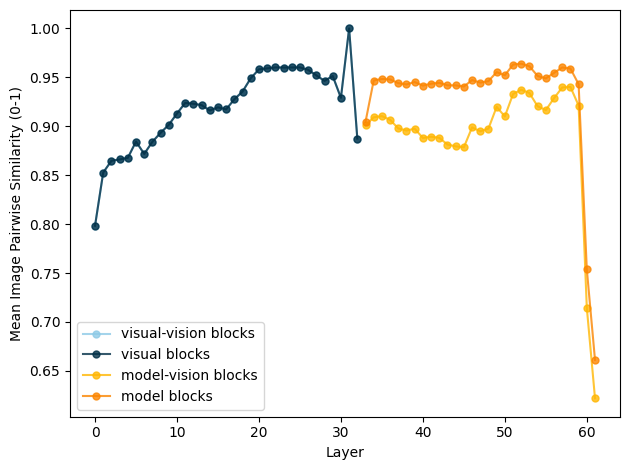

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Layer', ylabel='Mean Image Pairwise Similarity (0-1)'>)

In [ ]:
# For each layer, calculate the mean similarity and the norm
mean_embeddings = {}
mean_similarities = {}
for idx, (name, embs, sims) in enumerate(zip(m_names, m_embeddings, m_similarities)):
    # if idx < 4:
    #     continue
    print(idx, name)
    key = name.split(".")[0]
    if "-" in name:
        key += "-{}".format(name.split("-")[1])
    # if key == "model":
    #     if "text+vision" in name:
    #         key += "-visual"
    if key in mean_embeddings:
        mean_embeddings[key].append(np.mean(embs))
    else:
        mean_embeddings[key] = [np.mean(embs)]

    if key in mean_similarities:
        mean_similarities[key].append(np.mean(sims))
    else:
        mean_similarities[key] = [np.mean(sims)]

# Plot mean image-pair similarity scores by layer
xs = []
ys = []
labels = []
n_items = 0
n_vision_layers = len(m_embeddings["visual"]) # TODO: might throw an error if "visual" is wrong key
for k, v in mean_similarities.items():
    if k.startswith("model"):
        xs.append([i + n_vision_layers for i in range(len(v))])
    else:
        xs.append([i for i in range(len(v))])
    ys.append(v)
    labels.append("{} blocks".format(k))

print(ys)
visualizations.plot(
    xs=xs,
    ys=ys,
    labels=labels,
    alpha=0.8,
    xlabel='Layer',
    ylabel='Mean Image Pairwise Similarity (0-1)',
    show=True
)


# Qwen-2-VL-7B-Instruct

In [17]:
sys.argv = ['notebooks/track_mean_sims_across_layers.ipynb',
            '--config', '../configs/models/qwen/Qwen2-VL-7B-Instruct-VisualBlocks.yaml']

config = Config()
model = get_model(config.architecture, config)

Loading checkpoint shards: 100%|██████████| 5/5 [00:00<00:00, 24.45it/s]


In [18]:
print("{:.3f}B parameters".format(model.model.num_parameters() / 1e9))
print(model.model)

8.291B parameters
Qwen2VLForConditionalGeneration(
  (visual): Qwen2VisionTransformerPretrainedModel(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2VLVisionBlock(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): VisionSdpaAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): VisionMlp(
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (act): QuickGELUActivation()
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
    )
    (merger): PatchMerger(
      (ln_q): LayerNorm((1280,), eps=1e-06, elementwise_affine=True

In [20]:
n_modules = 0
for name, module in model.model.named_modules():
    if model.config.matches_module(name):
        print(name)
        n_modules += 1
print("{} modules matched".format(n_modules))

visual.blocks.0
visual.blocks.1
visual.blocks.2
visual.blocks.3
visual.blocks.4
visual.blocks.5
visual.blocks.6
visual.blocks.7
visual.blocks.8
visual.blocks.9
visual.blocks.10
visual.blocks.11
visual.blocks.12
visual.blocks.13
visual.blocks.14
visual.blocks.15
visual.blocks.16
visual.blocks.17
visual.blocks.18
visual.blocks.19
visual.blocks.20
visual.blocks.21
visual.blocks.22
visual.blocks.23
visual.blocks.24
visual.blocks.25
visual.blocks.26
visual.blocks.27
visual.blocks.28
visual.blocks.29
visual.blocks.30
visual.blocks.31
visual.merger
model.layers.0
model.layers.1
model.layers.2
model.layers.3
model.layers.4
model.layers.5
model.layers.6
model.layers.7
model.layers.8
model.layers.9
model.layers.10
model.layers.11
model.layers.12
model.layers.13
model.layers.14
model.layers.15
model.layers.16
model.layers.17
model.layers.18
model.layers.19
model.layers.20
model.layers.21
model.layers.22
model.layers.23
model.layers.24
model.layers.25
model.layers.26
model.layers.27
model.norm
62 

In [21]:
# Run model on images
model.run(save_tokens=True)

Running forward hooks on data: 100%|██████████| 50/50 [01:46<00:00,  2.14s/it]


In [22]:
db_path = model.config.output_db
utils.informal_log("Database path: {}".format(db_path))

module_names, module_embeddings, module_similarities = similarity_utils.compute_image_pair_similarities(
    database_path=db_path,
    model=model,
    layer_names=None,
    modalities=['vision', "text+vision"])

[1021_113514] Database path: ../output/Qwen2-VL-7B-Instruct-VisualBlocks.db


100%|██████████| 62/62 [00:54<00:00,  1.13it/s]


[[np.float64(0.7994299686113051), np.float64(0.8547120893577029), np.float64(0.8651254107276206), np.float64(0.8661267058443011), np.float64(0.8687384192599589), np.float64(0.8831199363568376), np.float64(0.872086220747739), np.float64(0.8823589466935029), np.float64(0.8896242504249662), np.float64(0.8950043338143446), np.float64(0.9053625854328579), np.float64(0.9183604495565936), np.float64(0.9173168463127627), np.float64(0.9154565977824767), np.float64(0.9112805001212956), np.float64(0.9159070700281102), np.float64(0.9168225333955161), np.float64(0.9275360680897523), np.float64(0.9361267515955785), np.float64(0.9507731832852042), np.float64(0.9608175870582603), np.float64(0.9642250424187311), np.float64(0.967450058731118), np.float64(0.9696277451847665), np.float64(0.9713810706307383), np.float64(0.9717950498474984), np.float64(0.971255887992787), np.float64(0.9678899102646829), np.float64(0.9643975365526187), np.float64(0.9625576473139534), np.float64(0.9493802543575888), np.float6

<Figure size 640x480 with 0 Axes>

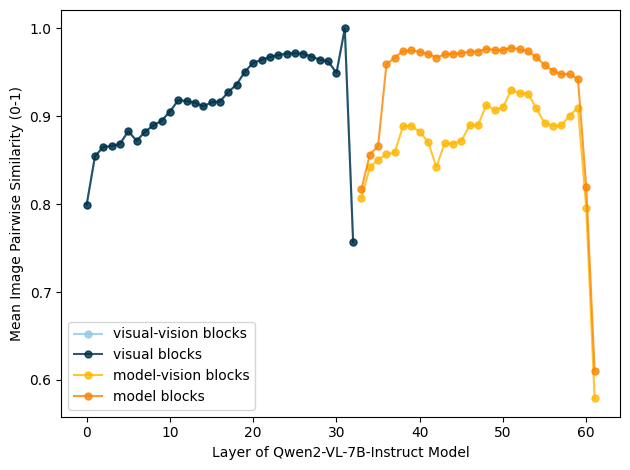

In [29]:
plot_similarities(
    module_names=module_names,
    module_embeddings=module_embeddings,
    module_similarities=module_similarities,
    model_name=model.config.model_path.split('/')[-1]
)

# LLaVA-1.5-7B

In [15]:
sys.argv = ['notebooks/track_mean_sims_across_layers.ipynb',
            '--config', '../configs/models/llava/LLaVA-1.5-7B-VisualBlocks.yaml']

config = Config()
model = get_model(config.architecture, config)

Loading checkpoint shards: 100%|██████████| 3/3 [00:11<00:00,  3.90s/it]


In [16]:
print("{:.3f}B parameters".format(model.model.num_parameters() / 1e9))
print(model.model)

7.063B parameters
LlavaForConditionalGeneration(
  (vision_tower): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(577, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-23): 24 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              